# Mini-project: Answering business questions with SQL
## Nadir Nibras
Importing libaries 

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Note that we are working exclusively with the "chinook.db" database in this project with data from the Store, Chinook.

We create a run_query() function, that takes a SQL query as an argument and returns a pandas dataframe of that query:

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

We'll also create a run_command() function that takes a SQL command as an argument and executes it using the sqlite module.

In [4]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

We will now create a a show_tables() function that calls the run_query() function to return a list of all tables and views in the database.

In [5]:
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

Running functions

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Analyzing sales by genre
### Task:

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

    Artist            Genre
    Regal	         Hip-Hop
    Red Tone	      Punk
    Meteor            Pop
    Slim Jim Bites	Blues

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

You'll need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

- Write a query that returns each genre, with the number of tracks sold in absolute numbers and in percentages.
- Create a plot to show this data.
- Write a paragraph that interprets the data and makes a recommendation for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres.

In [7]:
# Creating subquery to pull up dataframe of US customers first

q1 = '''
WITH us_tracks_data AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre_name,
    count(utd.invoice_line_id) tracks_sold,
    100*cast(count(utd.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from us_tracks_data
    ) percentage_sold
FROM us_tracks_data utd
INNER JOIN track t on t.track_id = utd.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY genre_name
ORDER BY tracks_sold DESC

'''
run_query(q1)

,genre_name,tracks_sold,percentage_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


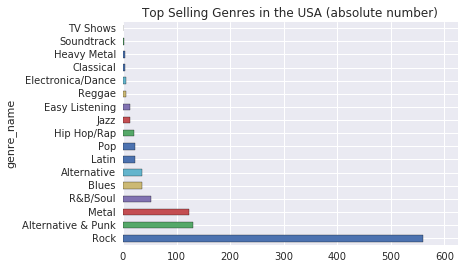

In [8]:
genre_data= run_query(q1)
genre_data.set_index("genre_name", inplace=True, drop=True)
genre_data["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA (absolute number)",
    xlim=(0, 625))

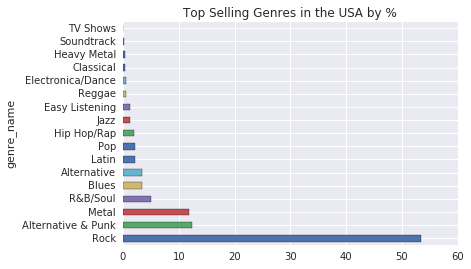

In [9]:
genre_data["percentage_sold"].plot.barh(
    title="Top Selling Genres in the USA by %",
    xlim=(0, 60)
    )

It seems that, historically speaking, the trends for highest sales would go to punk, blues, pop and hip-hop, in that order. But it would be interesting to also observe how sales have played out in more recent years before making a business decision

## Analyzing sales support agent performance
Write a query that finds the total dollar amount of sales assigned to each sales support agent within the company. Add any extra attributes for that employee that you find are relevant to the analysis.
Create a plot of the results of your query.
Write a short statement describing your results, and providing a possible interpretation.

In [10]:
sale_per_support_agent = '''

WITH customer_sales_total AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c 
         ON i.customer_id = c.customer_id
     GROUP BY i.customer_id
    )

SELECT
    e.first_name || " " || e.last_name employee_name,
    SUM(cst.total) total_sales
    
FROM customer_sales_total cst
INNER JOIN employee e 
    ON e.employee_id = cst.support_rep_id
GROUP BY employee_name
'''

run_query(sale_per_support_agent)

,employee_name,total_sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


There are just 3 sales reps for this store, and they all have made sales in the range of around $1390-1730
Note: for the code above it's important to first group by customer id: to get the total sales per customer, and then group by employee id to get the total per employees. Note that this works only because each customer only dealt with just one sales rep regardless of how many purchases they made

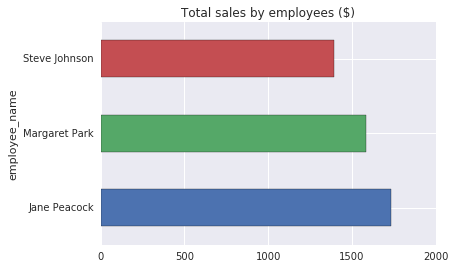

In [11]:
employee_sales= run_query(sale_per_support_agent)
employee_sales.set_index("employee_name", inplace=True, drop=True)

employee_sales["total_sales"].plot.barh(
    title="Total sales by employees ($)",
    xlim=(0, 2000),
)

## Analyzing sales by Country
Write a query that collates data on purchases from different countries. For each country, include:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

where a country has only one customer, collect them into an "Other" group.

The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.

### Notes- Explaining query logic
#### Country_as_other:
- selects all columns from invoice_line- includes information on how many tracks per invoice and the unit pricer per track
- selects customer_id from customer table
- selects customer's country from customer table 
--CASE ensures that customers who are the only one from their country have their country renamed to "Other". 
--"WHERE country = c.country" matches the country-name within the subquery with the one being used outside this subquery
- invoice is the connecting table between invoice_line and customer

#### dataframe constructed by main query:
- 1st part of main query simply extracts all the columns except for the "sort" column that is used for placing "Other" countries at the bottom
- primary sorting method puts "other" countries at bottom
- secondary sorting method sorts by total sales by country


In [12]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*) FROM customer
                 WHERE country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(DISTINCT customer_id) customer_lifetime_value,
        SUM(unit_price) / count(DISTINCT invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


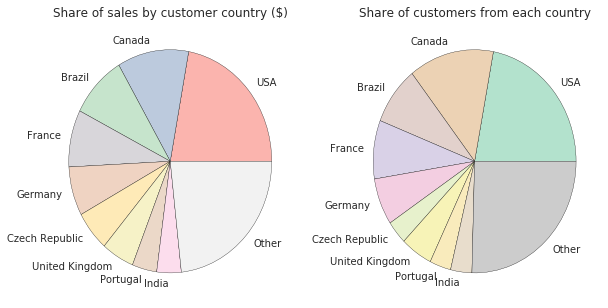

In [13]:
country_data= run_query(sales_by_country)
country_data.set_index("country", inplace=True, drop=True)


fig, axes = plt.subplots(nrows=1, ncols=2,    figsize=(10, 5),)
ax1, ax2 = axes.flatten()


country_data_dollars = country_data["total_sales"].copy().rename('')

country_data_dollars.plot.pie(
    ax= ax1,
    title="Share of sales by customer country ($)",
    colormap=plt.cm.Pastel1   
)

country_data_customer_number = country_data["customers"].copy().rename('')
country_data_customer_number.plot.pie(
    ax= ax2,
    title="Share of customers from each country",
    colormap=plt.cm.Pastel2   
)


The share of total customers from each country seem to be proptional to the share of total sales to people from that country. This intiutively makes sense.The largest shares are from North American countries.

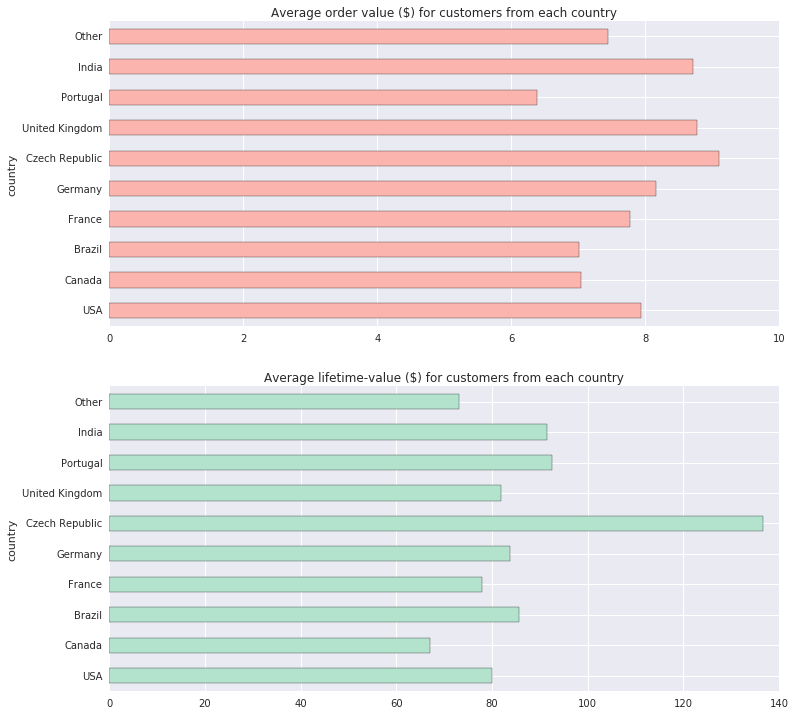

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1,    figsize=(12, 12),)
ax3, ax4= axes.flatten()

country_data_average_order = country_data["average_order"].copy().rename('')
country_data_average_order.plot.barh(
    ax= ax3,
    title="Average order value ($) for customers from each country",
    colormap=plt.cm.Pastel1   
)

country_data_average_lifetime = country_data["customer_lifetime_value"].copy().rename('')
country_data_average_lifetime.plot.barh(
    ax= ax4,
    title="Average lifetime-value ($) for customers from each country",
    colormap=plt.cm.Pastel2   
)

The average order value for customers from a country and the average liftime value of a customer from that country do not seem to be strongly correlated (verified that in the segment below). 
Czech people seem to be only slightly ahead of the pack when it comes to average order value, but they are significantly ahead of the rest when we looks at lifetime value. However there are only 2 customers from the Czech Republic so this isn't necessarily enough data to come to any conclusions about Czech customers

In [15]:
country_data[["average_order","customer_lifetime_value"]].corr()

,average_order,customer_lifetime_value
average_order,1.000000,0.498845
customer_lifetime_value,0.498845,1.000000
